# Seasonality in Boston Index Crime rates
> A story of peaks and valleys.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Wilfried F.
- image: images/crime-clock.jpeg
- categories: [notebook, jupyter, python, time series analysis]

![](https://h7r.github.io/fast/images/crime-clock.jpeg "FBI Crime Clock")

>"Truth is not always in a well. In fact, as regards the more important knowledge, I do believe that she is invariably superficial. The depth lies in the valleys where we seek her, and not upon the mountain-tops where she is found."

>"By undue profundity we perplex and enfeeble thought; and it is possible to make even Venus herself vanish from the firmament by a scrutiny too sustained, too concentrated, or too direct."

>"It will be found, in fact, that the ingenious are always fanciful, and the truly imaginative never otherwise than analytic."

>— *Edgar Allan Poe, The Murders in the Rue Morgue (1841)*

### Be like a sniffer dog

Not a fun fact: in 2017, a violent crime occurred every 24.6 seconds according to the FBI Crime Clock [[1]](#fn1). This is the kind of statistics found "upon the mountain-tops", by collecting mountains and mountains of daily crime data never ending. And the final result is reduced to this curious snapshot, like a nightmarish *memento mori*, namely the "FBI Crime Clock": time is money, but danger lurks around every corner... A travel advisory issued by your embassy about a failed state would not have been more explicit. Do Not Travel! Reconsider!

It is possible to make even the Six Grandfathers themselves vanish from the firmament of Mount Rushmore by such a sustained scrutiny into war on crime. Terrific decimal: 24.6. Better to never look at the watch, in fact. Nobody can breathe with such a number in mind. And there are a lot of records equally disturbing: 30.5 minutes (murders), 3.9 minutes (rapes), 1.7 minutes (robbery), etc. Ignorance of time is bliss.

Another quote from the same authority:

> The 2017 violent crime rate was 382.9 per 100,000 inhabitants, down 0.9 percent when compared with the 2016 violent crime rate. *[[2]](#fn2)*

How do you feel? Better, right?

Change the scale and you tell another story.

The truth that matters, the more important knowledge, says the detective Dupin-Poe, is *invariably superficial*, and lies in the valleys where we seek her. If not, we perplex and enfeeble thought. The Bostonian expert in solving enigmas is pro-Occam's razor. No need to undue profundity. Since "The Purloined letter" is *hidden in plain sight* [[3]](#fn3), why should I look in a well? "Show the data!", warms Jeef Leek [[4]](#fn4). 

So, this is a story of peaks and valleys, like in a Dow Jones chart. "Pictures are undervalued in science", wrote Benoît Mandelbrot in his excellent book *The (Mis)Behavior of Markets*. We agree with the French mathematician. We believe that pictures, good pictures and not *ridiculograms* [[5]](#fn5), are the royal road to *epiphanies*.

In this study, charts helped us a lot. Despite the noisy data, an unexpected pattern was showing up insistently from the very start: like temperature or influenza, *crime is seasonal*. Peak fever usually occurs in summer. Evidence pop up all over the data. Maybe it will be found, to paraphrase again Edgar Allan Poe, that data analysts are never otherwise than sniffer dogs following a promising track.

In [1]:
#hide
#general setup

from pathlib import Path

#prevent from warnings 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

In [5]:
daily.head()

2015-06-15    249
2015-06-16    258
2015-06-17    235
2015-06-18    294
2015-06-19    289
dtype: int64

In [2]:
#hide
# Load and prepare the data
usecols=[0,3,7,10,12,14,15]
index_col = "OCCURRED_ON_DATE"
path = Path.cwd().parent / 'data' / 'boston_2020-10-03.csv'
data=pd.read_csv(path, index_col=index_col, usecols=usecols, low_memory=False).sort_index()

#rename columns
col_names=["id","description","day_of_the_week","ucr","lat","long"]
to_rename=dict()
for idx, col in enumerate(data.columns):
    to_rename[col]=col_names[idx]
data=data.rename(columns=to_rename)

#rename index
data.index.rename("date",inplace=True)

#set datetime type for index
data.index = pd.to_datetime(pd.to_datetime(data.index).date)
#print(data.index.dtype)

#daily aggregate
daily = data.index.value_counts(sort=False).sort_index()
#print(daily.index.dtype)

#remove last day for which report is incomplete
daily=daily[0:len(daily)-1]

#define some useful lists
daily_index=daily.index

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']  
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [3]:
#hide
#print basic infos
print("Start at: " + str(data.index[0]))
print("End at: " + str(data.index[-1]))
print("Number of days: " + str(len(data.index.value_counts())))
print("Number of incidents (non uniques): " + str(len(data)))

#remove duplicated values
data = data.drop_duplicates()

#uncomment for sanity check
#print(data.duplicated().sum())

#check if missing values. There are missing value only for the columns "ucr" "lat" and "long" but we don't need them
#print(data.isnull().sum())

#print the top 30 offense types
print("\n")
print(data["description"].value_counts(ascending=False)[:30])

Start at: 2015-06-15 00:00:00
End at: 2020-10-03 00:00:00
Number of days: 1938
Number of incidents (non uniques): 518583
0
id                     0
description            0
day_of_the_week        0
ucr                91850
lat                29193
long               29193
dtype: int64


INVESTIGATE PERSON                       32285
SICK/INJURED/MEDICAL - PERSON            29203
VERBAL DISPUTE                           26418
M/V - LEAVING SCENE - PROPERTY DAMAGE    25831
VANDALISM                                23370
ASSAULT SIMPLE - BATTERY                 19876
INVESTIGATE PROPERTY                     18742
TOWED MOTOR VEHICLE                      17631
THREATS TO DO BODILY HARM                14646
LARCENY THEFT FROM MV - NON-ACCESSORY    13976
LARCENY THEFT FROM BUILDING              13963
LARCENY SHOPLIFTING                      12668
PROPERTY - LOST                          12233
WARRANT ARREST                           10965
LARCENY ALL OTHERS                        9913
M/V ACC

<a id='fig1'></a>

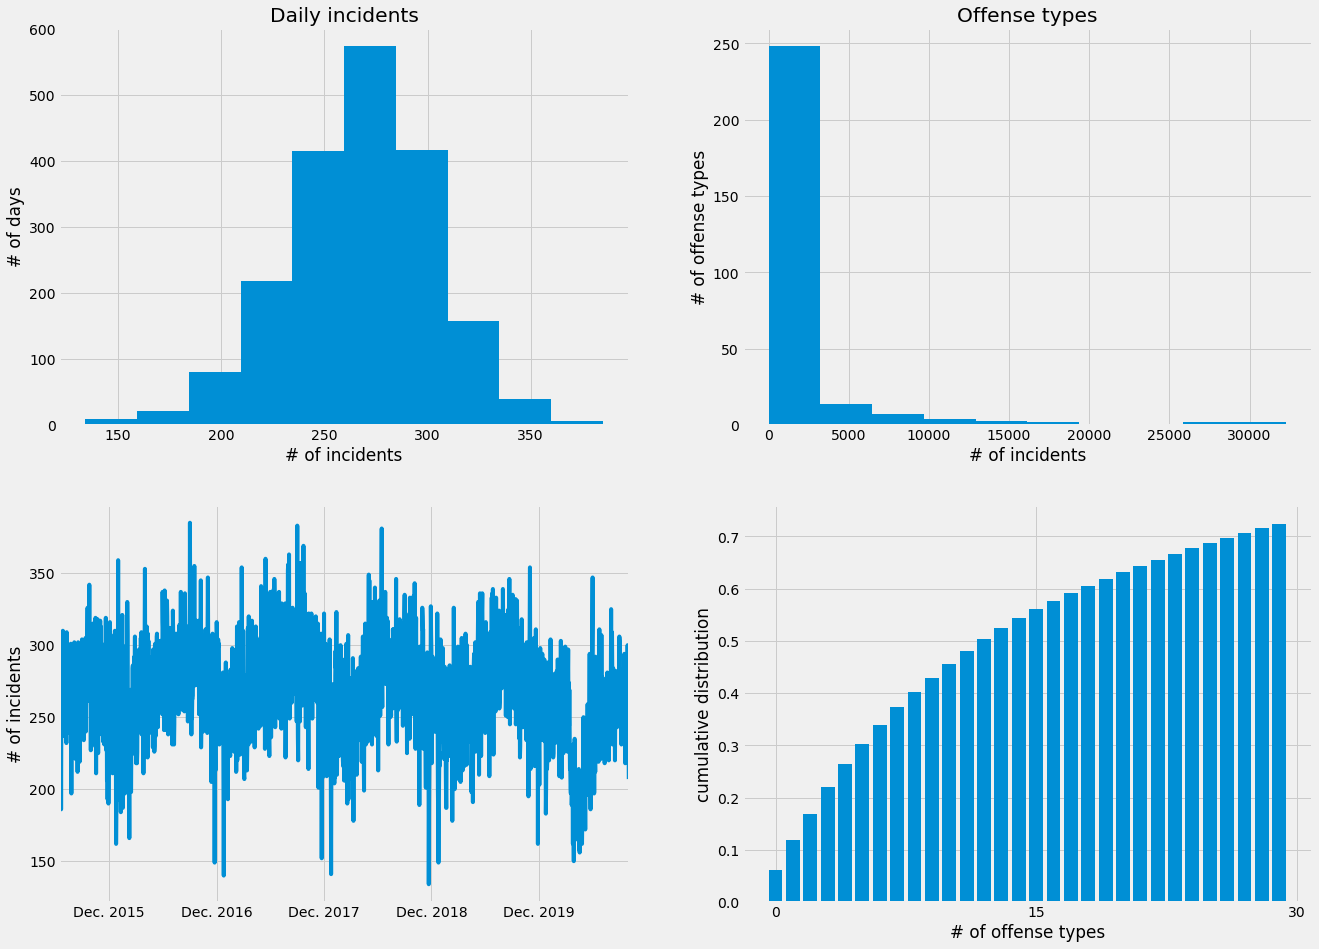

In [25]:
#hide_input 
locator = mdates.MonthLocator(12)
fmt = mdates.DateFormatter('%b. %Y')

fig, ax = plt.subplots(2,2, figsize=(20, 15))

ax[0,0].hist(daily)
ax[0,0].set_title("Daily incidents")
ax[0,0].set_xlabel("# of incidents")
ax[0,0].set_ylabel("# of days")

ax[1,0].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_formatter(fmt)
ax[1,0].set_xlim(daily.index[0],daily.index[-1])
ax[1,0].plot(daily.index,daily)
ax[1,0].set_ylabel("# of incidents")

ax[0,1].hist(data["description"].value_counts())
ax[0,1].set_xlabel("# of incidents")
ax[0,1].set_ylabel("# of offense types")
ax[0,1].set_title("Offense types")

sum_counts = np.sum(data["description"].value_counts())
cdf = data["description"].value_counts(ascending=False).cumsum()[:30]
ax[1,1].bar(range(30),cdf/sum_counts)
ax[1,1].set_xlabel("# of offense types")
ax[1,1].set_xticks(range(0,45,15))
ax[1,1].set_ylabel("cumulative distribution")

plt.show()

<span class="caption"><strong>Fig. 1. — Crime Incident Reports overview.</strong> While the total number of incidents in Boston rarely exceeds 300 events on a single day (top left), following what looks like a perfect Gaussian distribution, the raw daily data is obscured by seasonal oscillations and a certain amount of stochasticity (bottom left). Note the sudden drop on bottom left: it occurs right after the State of Emergency is declared on March 23, 2020. When the Reopening is announced on May 18, the number of daily incidents increases first slowly then quickly a few days after, hitting a local maximum on June 1.</span>

### First clues of seasonality and lockdown effect

Seasonality is a classic pattern in criminology though still without being well understood by academics. The subject has been studied for over a century, starting with Quetelet [[6]](#fn6), Mister "Average Man", who was an ingenuous believer, like almost all the scientists of his time (19th century), in "natural" or inborn biological causes behind deviance (climate and/or other stupid factors like race, heredity, etc.). In his (narrow) mind, statistics will save the world and the Average Man will replace the old imperfect man great-grandpa was. Here we are. More domestic disputes in summer, why? Maybe the sun making new highs removes some unpleasant ancestral barriers. As a result, the Average Man deviates from the boring statistical mean and the standard deviation of his expected human behavior turns crazy... Maybe. Quetelet's claim: "the violence of the passions predominating in summer, excites to more frequent personal collisions". In other no mother tongue terms: the passions predominating in his brain (whatever the season), excites Quetelet to very frequent confusions between correlation and causation. 

More seriously, as mentioned by Dong *et al.* (2017) [[7]](#fn7):

> Considering one of the most noticeable consequences of global warming is a shift in weather patterns, either locally warming or cooling, there is a need to understand how crime rates may change in response to the new weather patterns.

Less water in some countries, for example, and I bet that the Average Man will shift too. He will deviate to survive and become *unpredictable*. Welcome to the Extremistan Man. The extremistan studies are born. Bye-bye Quetelet and Mediocristan! Easy.

So this is not very surprising whether the BPD Crime Incident Reports show seasonal variations though obscured by noisy data (bottom left, [Fig. 1](#fig1)). We need to build a *tool* to extract the long-term trend and not be fooled by randomness.

If we look carefully at the same bottom panel on left in [Fig. 1](#fig1), a substantial hole is drawn at the end of the series. The phenomenon starts in fact shortly before the State of Emergency is declared on March 23, 2020 by Governor Baker, and ends after the Reopening announcement [[8]](#fn8) on May 18: this is what we call the *lockdown effect* ([Fig. 2](#fig2)), *i.e.* an abnormal drop in the number of incidents due to the major part of the population being under strict control, empty streets and shops closed.

After the economy reopen, the crime quickly reopened too, and climaxed on June 1 for then coming back to its old routine made of sudden peaks and drops – the seasonal oscillations.

We will show *infra* that the June 1 spike is most likely related to George Floyd protests maybe not so peaceful but running hot in response to police brutality.

From this point of view, crime – crimes against property more precisely – is nothing but a kind of thermometer. You can use it for analysis purposes or ignore it, the thermometer says that burglary, auto-theft and vandalism have been the best riots indicators during George Floyd protests ([Fig. 6](#fig6)). Rinse, repeat: the data shows that these people didn't target *persons*, but *property*, at least in Boston. This is why we need good data science. Because truth matters. Don't be afraid to tell the truth. She is often an *outlier*, a surprising and beautiful outlier. In other words, truth is a "dramatic change" in the data. The truth is that George Floyd died under the ruthless knee of a white police officer. 

> [...] social catastrophes can override any seasonality and lead to dramatic changes in future crime rates. *(Dong *et al.*, 2017)*

That's it.

So, please, be careful when you remove outliers!

<a id='fig2'></a>

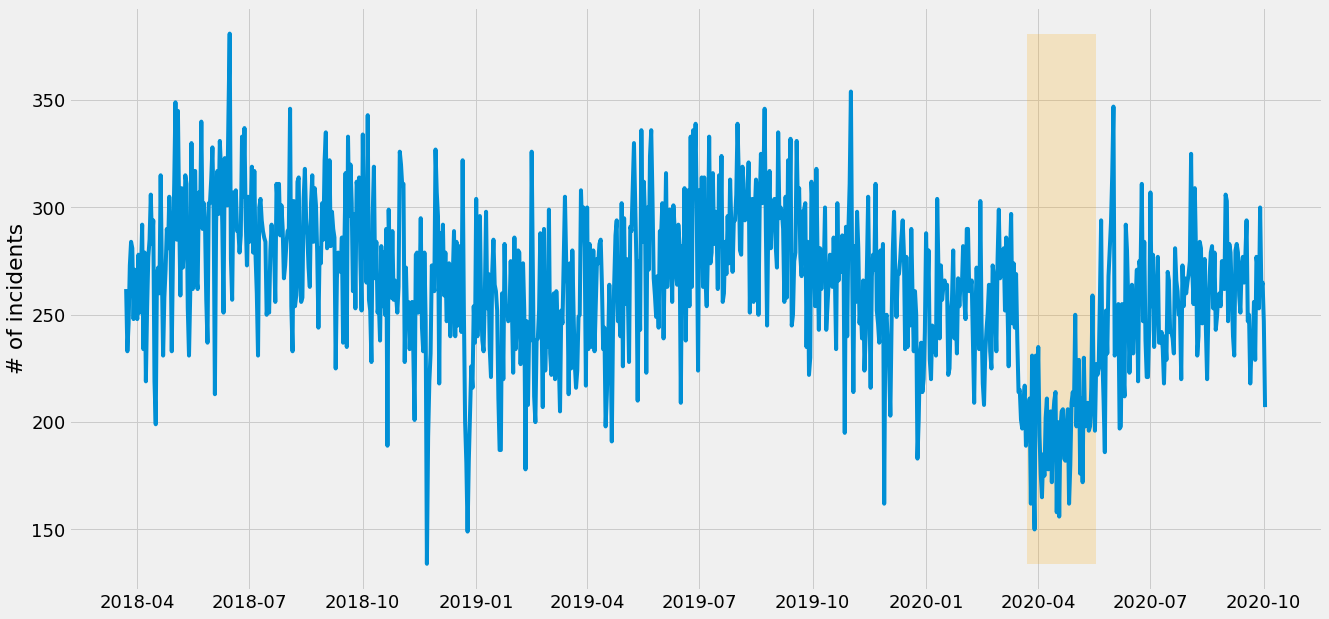

In [8]:
#hide_input
#plot Covid lockdown window
fig, ax = plt.subplots(figsize=(20, 10))
mn, mx = daily['2018-03-23':].min(), daily['2018-03-23':].max()
ax.plot(daily['2018-03-23':])
ax.set_ylabel("# of incidents")
#ax.set_xlim('2019-03-23',daily.index[-1])
ax.fill_between(('2020-03-23','2020-05-18'), mn, mx, facecolor='orange', alpha=0.2)

plt.show()

<span class="caption"><strong>Fig. 2. — Zoom on lockdown effect.</strong> A significant drop in crime rate occurs during the lockdown in Boston (orange shape). The short-term oscillations (seasonality) are not immune to brutal social changes. We'll show <i>infra</i> that the spike occurring on June 1 is due to George Floyd protests.</span>

After plotting a 2D heatmap ([Fig. 3](#fig3)), we see even better the seasonal pattern. The color interpolation indicates a three/four-month range where incidents are reported at a higher frequency. 

Next step: remove irrelevant offense types from the data.

<a id='fig3'></a>

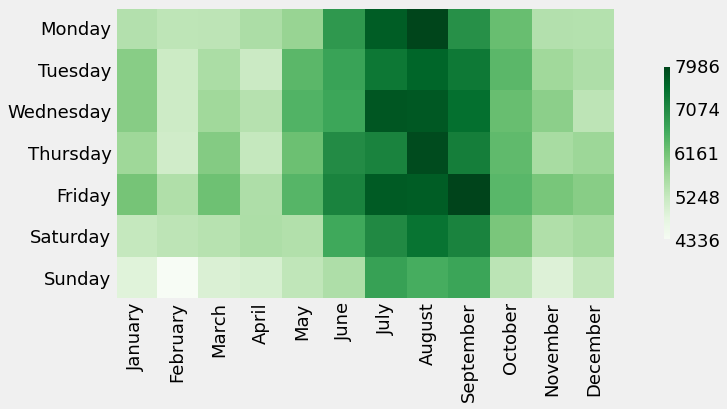

In [7]:
#hide_input
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.yticks(range(7), weekdays)
plt.xticks(range(12), months, rotation='vertical')
ar = np.zeros(shape=(7,12),dtype=np.float32)
for i in range(len(data)):        
        d=data.index[i].weekday() 
        m=data.index[i].month
        ar[d][m-1]+=1
img = ax.imshow(ar,plt.cm.Greens, interpolation='nearest')
ax.grid(False)
#ax.set_title("Fig. 3 - Daily incidents heatmap (by count)",fontsize=20)
bins = np.linspace(ar.min(), ar.max(), 5)
plt.colorbar(img, shrink=.6, ticks=bins)
plt.show()

<span class="caption"><strong>Fig. 3. — Daily incidents heatmap.</strong> The data have been reorganized in an array where each cell is the recipient of the total count of incidents that occurred a given weekday of a given month of the year. The darkest zone around the middle of the figure indicates that the number of incidents is usually highest between June and September.</span>

### Size doesn't matter: all we need is love and good data

The right panel in [Fig. 1](#fig1) shows also that offense types distribution is heavily unbalanced, exhibiting a large fat tail typical of a Pareto distribution skewed to the right. As a matter of fact, 10,5% of offense types account for 72,4% of the incidents, which is very close to the 80/20 rule [[9]](#fn9).

> twitter: https://twitter.com/DellAnnaLuca/status/1311671141816242177?ref_src=twsrc%5Etfw

Therefore, if we want to evaluate correctly the success —or the failure— of the public safety policy at Boston, it would be worth focusing only on the most relevant offense categories: those ones belonging to the said "Crime Index".

> [...] they are the crimes most likely to be reported and most likely to occur with sufficient frequency to provide an adequate basis for comparison. [...] The offenses included in the Crime Index total are the violent crimes of Murder and Nonnegligent Manslaughter, Forcible Rape, Robbery, and Aggravated Assault, and the property crimes of Burglary, Larceny-theft, and Motor Vehicle Theft. Arson is excluded due to inconsistent reporting. *[[10]](#fn10)*

By reducing our sample size and selecting carefully the offense types, our goal is to remove bias in the data collected by agents potentially involved in a *race for results* ("get those numbers and come back with them"), which may lead to serious misconducts [[11]](#fn11). 

The UCR Part I crimes [[12]](#fn12), or Crime index, are divided into two categories:&nbsp;violent crimes (*crime against persons*) and property crimes (*crime against property*):


|    Violent Crimes    	| Property Crimes 	|
|:---------------------:|:-----------------:|
| ASSAULT - AGGRAVATED 	|     LARCENY     	|
|        MURDER        	|    AUTO THEFT   	|
|        ROBBERY       	|      ARSON      	|
|         RAPE         	|     BURGLARY    	|


As mentioned above, Arson offenses have been excluded from the Index Crimes due to inconsistent reporting. But we are also forced to exclude the rapes from this study due to inconsistency in the BPD dataset regarding sexual assault (change in law).

In [11]:
#hide
def offenseExtractor(df, _name):
    """
    Inputs:
        df: a dataframe
        _name: a string or a regular expression
    Output: 
        a filtered dataframe which description column contains _name input
    """
    return(df.loc[(df['description'].str.contains(_name))])

def getIndexCrimes(data, _names):
    """
    Input:
        data (DataFrame): the data we want to create features (offense types) from.
         _names: a list of strings or regular expressions.

    Output:
        DataFrame: A DataFrame with index crimes as columns.
    
    Note: use pre-declared list daily_index
    """
    offenses = pd.DataFrame(index=daily_index)
    for _name in _names:
        offenses[_name] = aggregateBuilder(offenseExtractor(data, _name))
    return offenses

def aggregateBuilder(df):
    """
    Inputs:
        df: a time series DataFrame     
       
    Output: a daily aggregate (Series)
    
    Note: use pre-declared list daily_index
    """
    #aggregate by day of the year and sort the index
    s = df.index.value_counts(sort=False).sort_index()
    #reindex with daily_index and fill the missing days with 0 as value
    s = s.reindex(daily_index, fill_value=0)
    return s

def prepareHeatmap(df): #rename function?
    """
    input: a time series
    output: a numpy array with shape(7,12) which x-axis = weekday and y-axis = month
    """
    ar = np.zeros(shape=(7,12),dtype=np.float32)
    for i in range(len(df)):        
        d=df.index[i].weekday() 
        m=df.index[i].month
        ar[d][m-1]+=df.iloc[i]
    return ar

In [12]:
#hide
keywords= ["ASSAULT - AGGRAVATED", "ROBBERY", "MURDER", "LARCENY", "BURGLARY", "AUTO THEFT"]
index_crimes = getIndexCrimes(data, keywords)

In [13]:
#hide
index_crimes["violent_crimes"]=index_crimes.iloc[:,0:3].sum(axis=1)
index_crimes["property_crimes"]=index_crimes.iloc[:,3:6].sum(axis=1)
index_crimes["part_one_crimes"]=index_crimes.iloc[:,6:8].sum(axis=1)

#uncomment if you want to display the dataframe
#display(index_crimes.head())

<a id='fig4'></a>

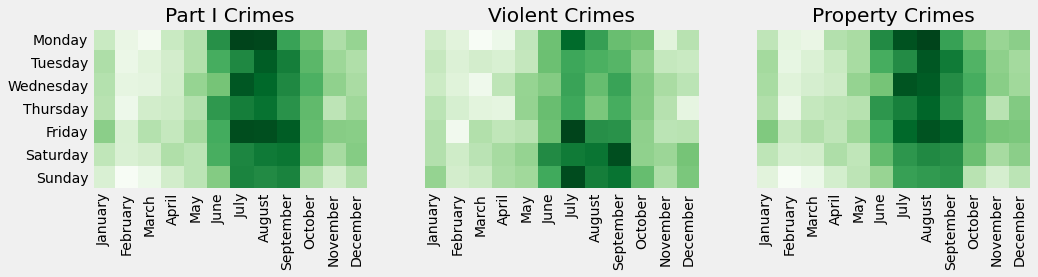

In [14]:
#hide_input
fig = plt.figure(figsize = (15,10))

titles= ["Part I Crimes", "Violent Crimes", "Property Crimes"]

#plt.yticks(range(21), weekdays*3)
#plt.xticks(range(12), months, rotation=90)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#plt.grid(False) 
#plt.set_xticklabels(range(12), months, rotation="vertical")

#fig.suptitle("Fig. 3 - Most serious crimes", fontsize=30) 

#plt.label_outer()
#plt.set_xticks(range(12), weekdays)
for i in range(0,3):    
    #img = ax[idx//2][0]
    if i == 0:        
        df = prepareHeatmap(index_crimes.part_one_crimes)
        ax1.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax1.set_title(titles[i])
        ax1.set_yticks(range(7))
        ax1.set_yticklabels(weekdays)
        ax1.set_xticks(range(12))
        ax1.set_xticklabels(months,rotation=90)
        ax1.grid(False)        
    elif i== 1:
        df = prepareHeatmap(index_crimes.violent_crimes)
        ax2.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax2.set_title(titles[i])
        ax2.set_yticks([])
        #ax2.set_yticklabels(weekdays)
        ax2.set_xticks(range(12))
        ax2.set_xticklabels(months,rotation=90)
        ax2.grid(False)       
    else:
        df = prepareHeatmap(index_crimes.property_crimes)
        ax3.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax3.set_title(titles[i])
        ax3.set_yticks([])
        #ax3.set_yticklabels(weekdays)
        ax3.set_xticks(range(12))
        ax3.set_xticklabels(months,rotation=90)
        ax3.grid(False)
    
    #title=title[idx] + " (" + str(int(np.sum(df))) + " obs.)"  
    #plt.title(title)
    #ax.set_xticklabels(months, rotation="vertical")
        
#fig.delaxes(ax[4,1])

<span class="caption"><strong>Fig. 4. — The most serious crimes.</strong> At first glance, Black Friday sales for crime shopping occurs in July. Spot seven differences between the left and the right heatmap is certainly a tough game. Sorry, no prize for the winner! It means that the weight of property crimes far exceeds the weight of violent crimes.</span>

The Part I Crimes as well as the property crimes heatmaps ([Fig. 4](#fig4)) look like a reduced snapshot of [Fig. 3](#fig3).

The same peak in (late) summer is still showing up despite we have strongly narrowed the data: the seasonality pattern is strong enough to be sample reduction resistant. 

Does it mean that the most serious crimes are something  —somewhere in the time or in the space—  predictable? The way to reduce the crime has been factorized by Lewitt (2004) [[13]](#fn13), it is a significant contribution though controversial. But the empire of crime is a complex space. Like a black hole with halo effect: easy to fall into, hard to quit without stigma for life regardless the extent of the criminal record [[14]](#fn14). And we have now examples of *Minority Report* emulators harassing innocent people based on big data and machine learning predictions [[15]](#fn15). The fact is that more and more studies are finding hidden bias in the data used during decades for training algorithms that finally are malicious enough to discretely discriminates minorities [[16]](#fn16).

However, the violent crimes rate is not converging so well toward a clear seasonal peak, as if spotting the crimes against persons was in fact the real challenge here. 

Is Boston doing better or worse than expected compared to other American cities?

![](https://h7r.github.io/fast/images/jingle_man.jpg "Edgar Allan Poe was dismissed as a 'The Jingle Man' by Emerson. But who remember Emerson? Time is a bitch.")

By performing SSA, we will be able to answer the question in the next section. 

### The trajectory space of the crime

We start by quoting again Dong *et al.* (2017), our main source of inspiration for this work:

>The first step in the SSA involves creating a trajectory matrix. For a time series $X = (x_1$, $x_2$,...,$x_N)$ and a window length $L = 365$, we define the trajectory matrix as:

$$
{\bf X} =
\begin{pmatrix}
x_1 & x_2 & x_3 & \cdots & x_K\\
x_2 & x_3 & x_4 & \cdots & x_{K+1}\\
x_3 & x_4 & x_5 & \cdots & x_{K+2}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
x_L & x_{L+1} & x_{L+2} & \vdots & x_N\\
\end{pmatrix}
$$

>with $K = N - L + 1$. Then a singular value decomposition (SVD) is performed on the trajectory matrix, providing a decomposition $X = X_1 + ⋯ + X_L$. Each of our modes then comes from averaging these matrices $X_i$ along their anti-diagonal. The mode with the largest singular value always corresponds to the average crime trend. We then typically would look for any modes with an annual periodicity in the first twenty singular values and sum these to produce our seasonal component.

Since we work under two constraints, time $t \ne \infty$ and budget $b\approx0$, we don't go into detail. For those interested in learning more about SSA, see [[9]](#fn9) and [[10]](#fn10).

Our purpose is to apply the SSA technique to Boston following [[4]](#fn4) guidelines.

In [15]:
#hide
from scipy.linalg import svd, diagsvd

In [16]:
#hide
#creating a trajectory matrix

def createLaggedVectors(s, L):
    """
    inputs:
        s : series or 1d array-like
        L : an integer (the window length - long-term timeframe we want to extract)
        
    output: a 2d numpy array (Hankel matrix - all the elements along the diagonal are equal)
    """    
    N = len(s) 
    K = N - L + 1    
    X = np.zeros(shape=(L,K),dtype=np.float64)
    for i in range (0,L):
        for j in range(0,K):
            X[i][j]+= s[j+i]    
    return X


def componentsExtractor(s,L):
    """
    inputs:
        s : series or 1d array-like
        L : an integer (the window length - long-term timeframe we want to extract)
        
    output: a 2d numpy array of shape (len(s) x L)
    """ 
    N = len(s)
    #trajectory matrix creation
    X = createLaggedVectors(s,L)
    #SVD decomposition avec scipy.linalg.svd
    U, s, VT = svd(X)
    #rank of the trajectory matrix, most of time d=L (no lineary dependence between columns of X)
    d = np.linalg.matrix_rank(X)
    #reconstruction
    X_components = np.zeros((N, L))
    
    #thanks to Joan d'Arcy Kaggle notebook [10] for the code below 
    for i in range(0,d):
        #the tricky part: eigentriple grouping
        X_elem = s[i]*np.outer(U[:,i], VT[i,:])
        X_rev = X_elem[::-1]
        #diagonal averaging
        X_components[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
    return X_components

def checkAccuracy(s,ssa_array):
    """
    Check if no error rebuilding the data time series from the eigentriples array
    inputs:
        s : series or 1d array-like
        ssa_array : 2d numpy array containing the eigentriples as columns
        
    output: True or False
    """ 
    return np.allclose(s,np.sum(ssa_df,axis=1))

In [17]:
#hide
#uncomment for sanity check example

#violent_crimes_ssa = componentsExtractor(index_crimes.violent_crimes, 365)
# print(checkAccuracy(index_crimes.violent_crimes,violent_crimes_ssa))

In [18]:
#hide
#daily_ssa = componentsExtractor(daily, 365)

part_one_crimes_ssa = componentsExtractor(index_crimes.part_one_crimes, 365)
violent_crimes_ssa = componentsExtractor(index_crimes.violent_crimes, 365)
property_crimes_ssa = componentsExtractor(index_crimes.property_crimes, 365)

#separate trend component from seasonal component
part_one_crimes_trend = pd.Series(part_one_crimes_ssa[:,0],daily_index)
part_one_crimes_seasonal = pd.Series(part_one_crimes_ssa[:,0:3].sum(axis=1),daily_index)
violent_crimes_trend = pd.Series(violent_crimes_ssa[:,0],daily_index)
violent_crimes_seasonal = pd.Series(violent_crimes_ssa[:,0:3].sum(axis=1),daily_index)
property_crimes_trend = pd.Series(property_crimes_ssa[:,0],daily_index)
property_crimes_seasonal = pd.Series(property_crimes_ssa[:,0:3].sum(axis=1),daily_index)

<a id="fig5"></a>

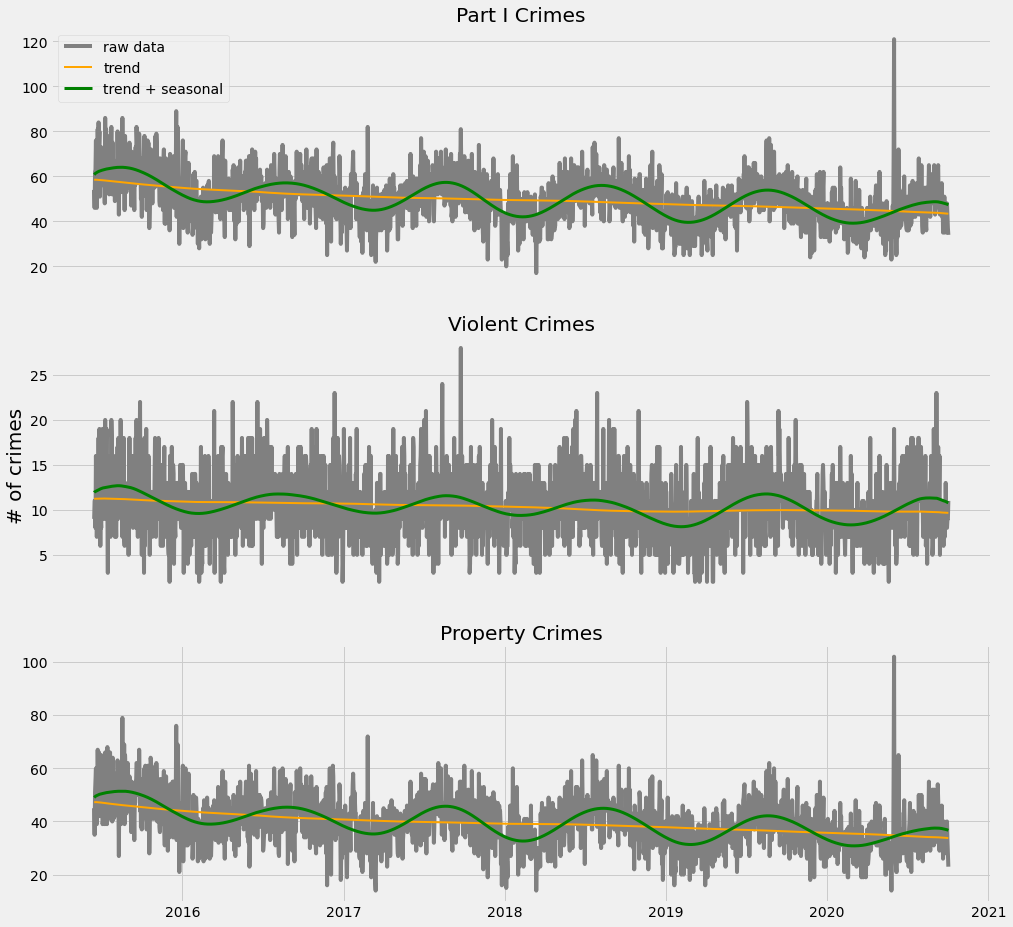

In [19]:
#hide_input
titles= ["Part I Crimes", "Violent Crimes", "Property Crimes"]

fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

#fig.suptitle("Fig. 4 - Most serious crimes with SSA components",fontsize=30)

for i in range(0,3):        
    if i == 0:        
        ax1.plot(index_crimes.part_one_crimes,color="grey",label="raw data")
        ax1.plot(part_one_crimes_trend,color="orange",linewidth=2, label="trend")
        ax1.plot(part_one_crimes_seasonal,color="green",linewidth=3,label="trend + seasonal")
        ax1.set_title(titles[i])
        ax1.set_xticks([])        
        ax1.legend()        
          
    elif i== 1:        
        ax2.plot(index_crimes.violent_crimes,color="grey",label="raw data")
        ax2.plot(violent_crimes_trend,color="orange",linewidth=2, label="trend")
        ax2.plot(violent_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")
        ax2.set_title(titles[i])
        ax2.set_xticks([])        
        ax2.set_ylabel("# of crimes", fontsize=20)
    else:        
        ax3.plot(index_crimes.property_crimes,color="grey",label="raw data")
        ax3.plot(property_crimes_trend,color="orange",linewidth=2, label="trend")
        ax3.plot(property_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")
        ax3.set_title(titles[i])

plt.show()

<span class="caption"><strong>Fig. 5. — The most serious crimes with their SSA components.</strong> Daily aggregates are plotted in grey, long-term trends in yellow, and the green curves are the long-term trends plus the first two seasonal components (ET1-3). See the big outlier on the right? </span>

Recap:
* SSA technique makes an *additive decomposition* of a time series $X$ of length $N$ (the diagonal of the trajectory matrix) into a sum of $L$ components of length $N$. To reconstruct the time series, simply sum the $L$ components and make a sanity check.
* The mode with the largest values, i.e. the first *elementary reconstructed series* or first *eigentriple* (ET1), is the long-term trend.
* We sum the first other modes with annual periodicity to produce the seasonal component.

#### *Long-term trends extraction (the signal)*

The Index Crimes in Boston are slowly falling accordingly to the national tendency [[11]](#fn11), but this is due above all to a sharp decline in property crimes frequency, while violent crimes long-term trend is flat as a hell ([Fig. 5](#fig5)). Due to very low amplitude, annual variations for violent crimes would be almost impossible to detect without the SSA technique. 

Back to the original dataset. Three offense types exhibit the same outlier  ([Fig. 6](#fig6)):
- BURGLARY - COMMERICAL (*sic*)
- AUTO THEFT
- VANDALISM

Quick research confirms that George Floyd protests in Boston streets on May 31 have ended in violence [[12]](#fn12). The many incidents have been reported by BDP one day later, on June 1, resulting in the outlier in the data.

We will now emphasize both violent crimes and property crimes long trends by zooming on their respective subcategories.

<a id="fig6"></a>

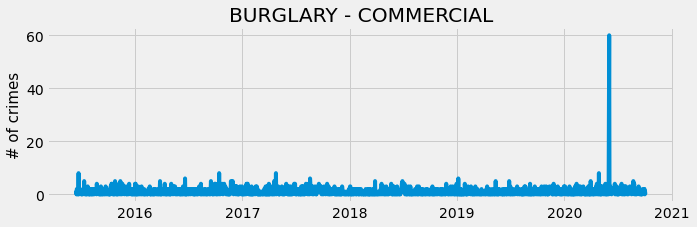

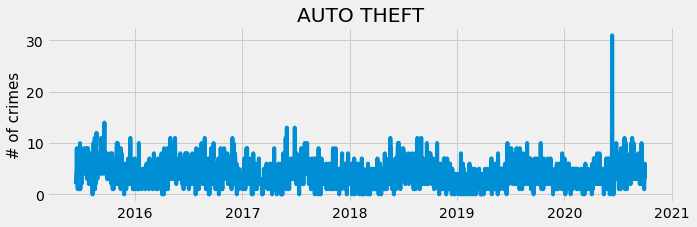

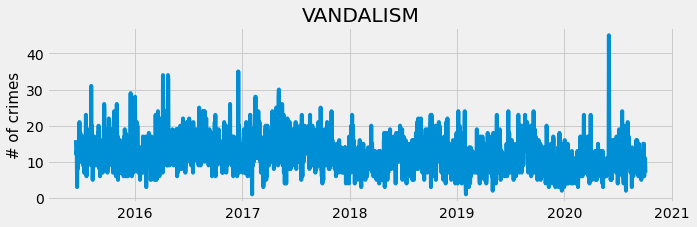

In [20]:
#hide_input
plt.figure(figsize=(10,3))
daily_offenses = aggregateBuilder(offenseExtractor(data,"BURGLARY - COMMERICAL"))
plt.plot(daily_offenses)
plt.ylabel("# of crimes", fontsize=15)
plt.title("BURGLARY - COMMERCIAL")
plt.show()
plt.figure(figsize=(10,3))
daily_offenses = aggregateBuilder(offenseExtractor(data,"AUTO THEFT"))
plt.plot(daily_offenses)
plt.ylabel("# of crimes", fontsize=15)
plt.title("AUTO THEFT")
plt.show()
plt.figure(figsize=(10,3))
daily_offenses = aggregateBuilder(offenseExtractor(data,"VANDALISM"))
plt.plot(daily_offenses)
plt.ylabel("# of crimes", fontsize=15)
plt.title("VANDALISM")
plt.show()

<span class="caption"><strong>Fig. 6. — Boston protests against George Floyd killing ending in violence.</strong> Commercial burglary, auto theft and vandalism exhibit the same spike on June 1, showing that these three offense types are the best markers for riots and looting.</span>

Though we observe a general decrease for Part I Crimes ([Fig. 5](#fig5)), the aggravated assaults are slightly on the rise and auto thefts have ceased to decrease after 2019, while the rate of decrease for burglary seems to be slowing ([Fig. 7](#fig7)). As mentioned by [[4]](#fn4):
> One possible cause is that crime is at very low basal level, and it is hard to decrease it below this level.

In [21]:
#hide
violent_crimes_list = ['ASSAULT - AGGRAVATED', 'MURDER', 'ROBBERY']
property_crimes_list = ['LARCENY', 'AUTO THEFT', 'BURGLARY']
years=[2015,2016,2017,2018,2019,2020,2021]

<a id="fig7"></a>

<ipython-input-22-8788afb0e16c>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["",0.6,0.8,1.,1.2,""])
<ipython-input-22-8788afb0e16c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(years)


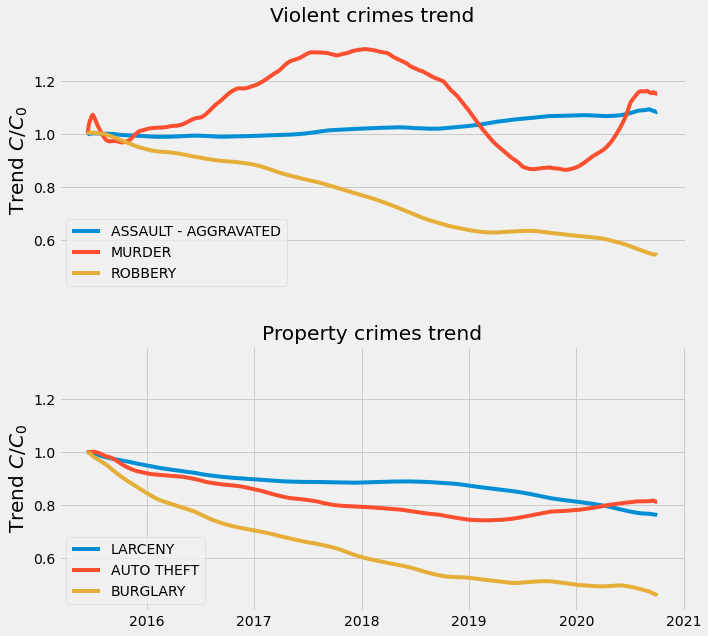

In [22]:
#hide_input
fig, ax = plt.subplots(2,1,  figsize=(10,10))

ylabel = "Trend $C$/$C_0$"

for i in range(0,2):
    #plt.suptitle("Fig. 5 - long-term trends by subcategories", fontsize=30)   
    if i == 0:        
        off_list = violent_crimes_list
        ax[0].set_xticks([])
        title="Violent crimes trend"
    else: 
        off_list = property_crimes_list
        ax[1].set_xticklabels(years)        
        title="Property crimes trend"
        
    for idx, offense in enumerate(off_list):        
        ssa = componentsExtractor(index_crimes[offense], 365)[:,0]

        trend = pd.Series(ssa, index=daily_index) 
        #normalize the values 
        s = (1+trend.pct_change()).cumprod().fillna(1) 

        ax[i].plot(s) 
    ax[i].set_ylabel(ylabel, fontsize=20) 
    ax[i].set_ylim(0.4,1.4)    
    ax[i].set_yticklabels(["",0.6,0.8,1.,1.2,""])
    ax[i].set_title(title)
    ax[i].legend(off_list, loc="lower left")
        
plt.show()

<span class="caption"><strong>Fig. 7. — Long-term trends by subcategories.</strong> Following Donet <i>et al.</i> (2017), the data has been normalized "to be the fraction of the initial crime level for the first time point $C_0$". The Murder trend is pretty erratic, but keep in mind that homicides occur very rarely (less than 1 by day on average), so the variance is higher.</span>

This is a paradox: once reached very low levels of crime (proof of agents' good work), it becomes harder to lower the curve, and more likely to get bad results in the future (not proof of agents' bad work), losing therefore public funds. From this point of view, a public safety policy based only on quantified results is suboptimal and unfair to the agents, if not stressful for them (incentivizing the dangerous "race for results" pointed *supra*).

#### *Seasonal components extraction (the noise)*

To reconstruct the seasonal data, we will use the first $n$ leading SSA order modes, where $2 \leq n \leq4$, depending on the offense type, each one having a different periodicity.

Again, we have followed the procedure described in [[4]](#fn4):
> The trend is subtracted from the data and then the data is smoothed using a moving window average. As the oscillations are related to the total amount of crime, the data and seasonal component have been divided by the trend pointwise in time to normalize the oscillations.

Since our long-term window length $L = 365$, we have smoothed the data with a monthly window average of length $l = 30$ before normalizing the oscillations.

<a id="fig8"></a>

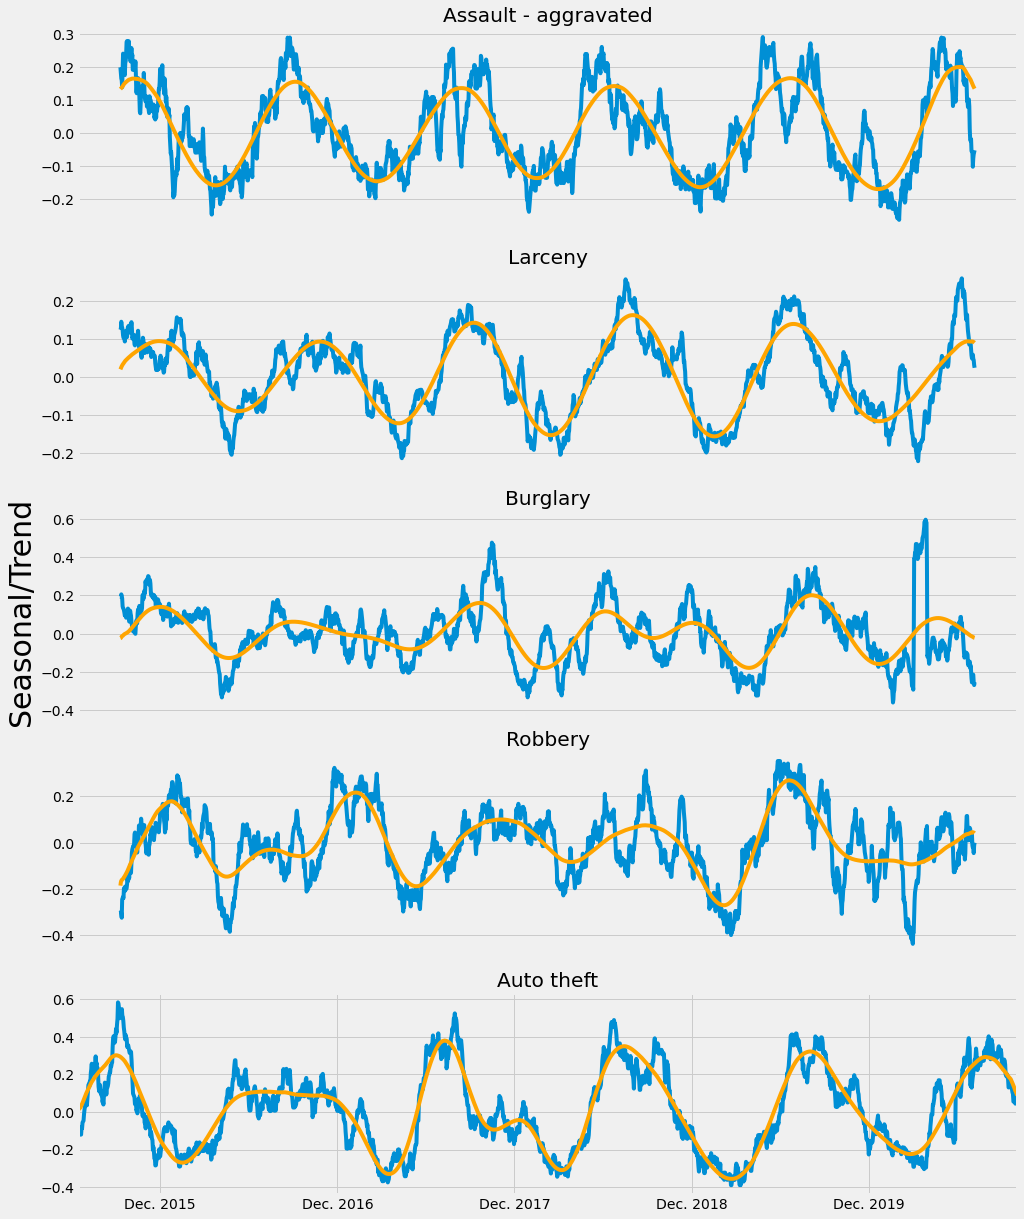

In [23]:
#hide_input
sorted_keywords = ['ASSAULT - AGGRAVATED', 'LARCENY', 'BURGLARY','ROBBERY', 'AUTO THEFT']

fig = plt.figure(figsize = (15,20))

#plt.yticks(range(21), weekdays*3)
#plt.xticks(range(12), months, rotation=90)
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)


#plt.xticks(rotation=45)

locator = mdates.MonthLocator(12)
fmt = mdates.DateFormatter('%b. %Y')

for i in range(0,5):    
    daily_offenses = index_crimes[sorted_keywords[i]]
    title = sorted_keywords[i][0]+sorted_keywords[i][1:].lower()
    if i<3:
        n=2
    elif i==3:
        n=3
    else:
        n=4
    ssa = componentsExtractor(daily_offenses, 365)[:,:n+1]
    seasonal, trend = pd.Series(ssa[:,1:n+1].sum(axis=1), index=daily_index), pd.Series(ssa[:,0], index=daily_index)
    #put the seasonal component and the raw data on the same order
    smoothed_daily_offenses = (daily_offenses-trend).rolling(30,min_periods=1,center=True).mean() / trend
    seasonal = seasonal/trend    
    if i== 0:
        ax1.plot(smoothed_daily_offenses, label="Raw data")
        ax1.plot(seasonal, label="Seasonal",color='orange')
        ax1.set_title(title)       
        ax1.set_xticks([])
    
    elif i== 1: 
        ax2.plot(smoothed_daily_offenses, label="Raw data")
        ax2.plot(seasonal, label="Seasonal component",color='orange')
        ax2.set_title(title)       
        ax2.set_xticks([])
        
    elif i == 2:
        ax3.plot(smoothed_daily_offenses, label="Raw data")
        ax3.plot(seasonal, label="Seasonal component",color='orange')
        ax3.set_title(title)       
        ax3.set_xticks([])
        ax3.set_ylabel("Seasonal/Trend", fontsize=30)
       
    elif i == 3:
        ax4.plot(smoothed_daily_offenses, label="Raw data")
        ax4.plot(seasonal, label="Seasonal component",color='orange')
        ax4.set_title(title)
        ax4.set_xticks([])
        
    else:
        ax5.plot(smoothed_daily_offenses, label="Raw data")
        ax5.plot(seasonal, label="Seasonal component",color='orange')
        ax5.set_title(title)       
        ax5.xaxis.set_major_locator(locator)
        ax5.xaxis.set_major_formatter(fmt)
        ax5.set_xlim(smoothed_daily_offenses.index[0],smoothed_daily_offenses.index[-1]) 
            

<span class="caption"><strong>Fig. 8. — Seasonal crime component.</strong> Even if the raw data has been smoothed, we see that the seasonal oscillations are fairly consistent, especially for aggravated assault, larceny and auto theft. In other words, each crime index type has a seasonal component. A large aberration appears for burglary during George Floyd protests, while a significant drop happens for robbery category during the lockdown, showing that robbery is the crime type that has been the most affected by State of Emergency.</span>

<a id="fig9"></a>

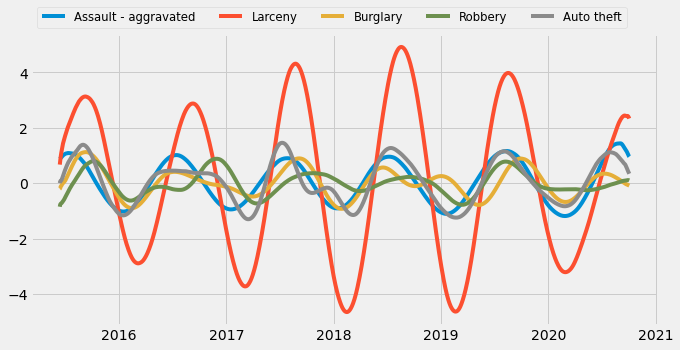

In [24]:
#hide_input
plt.figure(figsize=(10,5))
for i in range(0,5):    
    daily_offenses = aggregateBuilder(offenseExtractor(data,sorted_keywords[i]))
    title = sorted_keywords[i][0]+sorted_keywords[i][1:].lower()
    if i<3:
        n=2
    elif i==3:
        n=3
    else:
        n=4
    ssa = componentsExtractor(daily_offenses, 365)[:,:n+1]
    seasonal, trend = pd.Series(ssa[:,1:n+1].sum(axis=1), index=daily_index), pd.Series(ssa[:,0], index=daily_index)
    plt.plot(seasonal, label=title)
plt.legend(ncol=len(sorted_keywords), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
plt.show()  


<span class="caption"><strong>Fig. 9. — Differences in seasonality.</strong></span>

### References
- <span id="fn1">[1] FBI Crime Clock: </span> https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/topic-pages/crime-clock
- <span id="fn2">[2] Cf: </span> https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/topic-pages/tables/table-1
- <span id="fn3">[3] Wikipedia - The Purloined Letter: </span> https://en.wikipedia.org/wiki/The_Purloined_Letter
- <span id="fn4">[4] Prudent analyst: </span> http://jtleek.com/ads2020/week-5.html
- <span id="fn5">[5] Introduction to ridiculogram by M. E. J. Newman. Web. 2 July 2007: </span> https://www.youtube.com/watch?v=YS-asmU3p_4
- <span id="fn6">[6] Adolphe Quetelet - A Treatise on Man and the Development of His Faculties (1842): </span> https://archive.org/details/treatiseonmandev00quet/page/122/mode/2up
- <span id="fn7">[7] Dong, K., Cao, Y., Siercke, B., Wilber, M., & McCalla, S. G. (2017). Advising caution in studying seasonal oscillations in crime rates. PloS one, 12(9), e0185432: </span> https://doi.org/10.1371/journal.pone.0185432
- <span id="fn8">[8] Mass.gov - Reopening Massachusetts. May 18, 2020. [PDF]: </span> https://www.mass.gov/doc/reopening-massachusetts-may-18-2020/download
- <span id="fn9">[9] Wikipedia - Pareto principle: </span> https://en.wikipedia.org/wiki/Pareto_principle
- <span id="fn10">[10] USLegal - Index Crimes Law and Legal Definition.</span> https://definitions.uslegal.com/i/index-crimes/
- <span id="fn11">[11] The New York Times. By Michelle Alexander. Why Police Lie Under Oath. Web. Feb. 2, 2013.</span> https://www.nytimes.com/2013/02/03/opinion/sunday/why-police-officers-lie-under-oath.html?pagewanted=all&_r=0
- <span id="fn12">[12] FBI:UCR  • Crimes in the U.S. 2010  • Offenses Definitions.</span> https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/offense-definitions
- <span id="fn13">[13] Steven D. Levitt (2014) - Understanding Why Crime Fell in the 1990s: Four Factors that Explain the Decline and Six that Do Not Lewitt: </span> https://www.aeaweb.org/articles?id=10.1257/089533004773563485
- <span id="fn14">[14] Michele Berger - Stigma of criminal record stays with individual, regardless of crime type, conviction. August 17, 2016: </span> https://phys.org/news/2016-08-stigma-criminal-individual-crime-conviction.html
- <span id="fn15">[15] Kathellen McGrory and Neil Bedi - Targeted. Sept. 3, 2020: </span>  https://projects.tampabay.com/projects/2020/investigations/police-pasco-sheriff-targeted/intelligence-led-policing/?fbclid=IwAR3b4nQWPc8-4gryIjtoa1pCx_KWj84taNAN7oTEixicFEr45L3-6L1rRYk
- <span id="fn16">[16] Cf: </span> http://web.cs.ucla.edu/~kwchang/publications_area/

#hide
- <span id="fn5">[5] Analyse Boston - Crime Incident Reports (August 2015 - To Date) (Source: New System).</span> https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
- <span id="fn5">[5] Wikipedia - Singular spectrum analysis.</span> https://en.wikipedia.org/wiki/Singular_spectrum_analysis



- <span id="fn9">[9] Golyandina, Nina & Zhigljavsky, Anatoly. (2013). Singular Spectrum Analysis for Time Series. 10.1007/978-3-642-34913-3.</span> https://www.researchgate.net/publication/260124592_Singular_Spectrum_Analysis_for_Time_Series
- <span id="fn10">[10] Jordan D'Arcy - Kaggle Notebook, Introducing SSA for Time Series Decomposition.</span> https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
- <span id="fn11">[11] Brennan Center for Justice. Press Release. Crime Remains at Historic Lows in America. Web. June 12, 2018.</span> https://www.brennancenter.org/our-work/analysis-opinion/crime-remains-historic-lows-america
- <span id="fn12">[12] Boston Globe. By Jeremy C. Fox and John Hilliard. Boston protests against George Floyd killing begin peacefully, end in violence, arrests. Web. June 1, 2020.</span> https://www.bostonglobe.com/2020/05/31/metro/three-protests-against-george-floyd-killing-planned-boston-sunday/
